In [1]:
# imports de preparação e construção do modelo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
import matplotlib.pyplot as plt

# imports mlflows para modelo do sklearn
import mlflow
import mlflow.sklearn

In [2]:
credit = pd.read_csv('Credit.csv')
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [3]:
credit.shape

(1000, 21)

In [4]:
for col in credit.columns:
    if credit[col].dtype == 'object':
        credit[col] = credit[col].astype('category').cat.codes

In [5]:
credit.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,2,6,1,7,1169,0,3,4,3,2,...,2,67,1,1,2,3,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,...,2,22,1,1,1,3,1,0,1,0
2,0,12,1,4,2096,3,1,2,3,2,...,2,49,1,1,1,2,2,0,1,1
3,2,42,3,5,7882,3,1,2,3,1,...,0,45,1,0,1,3,2,0,1,1
4,2,24,2,1,4870,3,0,3,3,2,...,1,53,1,0,2,3,2,0,1,0


In [6]:
previsores = credit.iloc[:, 0:20].values
classe = credit.iloc[:, 20].values

In [7]:
previsores

array([[ 2,  6,  1, ...,  1,  1,  1],
       [ 1, 48,  3, ...,  1,  0,  1],
       [ 0, 12,  1, ...,  2,  0,  1],
       ...,
       [ 0, 12,  3, ...,  1,  0,  1],
       [ 2, 45,  3, ...,  1,  1,  1],
       [ 1, 45,  1, ...,  1,  0,  1]])

In [8]:
print("classes:", set(classe))

classes: {0, 1}


In [9]:
X_train, X_test, y_train, y_test = train_test_split(previsores, classe, train_size=0.7, random_state=0)

In [10]:
server = "http://localhost:5000"
mlflow.set_tracking_uri(server)

def train_skmodel(Model, dict_params:dict, experiment_name:str):
    # coloca um nome para um experimento
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run():
        mlflow.sklearn.autolog()

        model = Model(**dict_params)
        model.fit(X=X_train, y=y_train)
        pred = model.predict(X_test)

        # metricas de avaliação
        accuracy = accuracy_score(y_true=y_test, y_pred=pred)
        recall = recall_score(y_true=y_test, y_pred=pred)
        precision = precision_score(y_true=y_test, y_pred=pred)
        f1 = f1_score(y_true=y_test, y_pred=pred)
        auc = roc_auc_score(y_true=y_test, y_score=pred)
        log = log_loss(y_true=y_test, y_pred=pred)

        # graficos
        confusion = plot_confusion_matrix(model, X_test, y_test)
        plt.savefig('confusion-rf.png')
        roc = plot_roc_curve(model, X_test, y_test)
        plt.savefig('roc-rf.png')

        # registrar hiperparametros
        for param in dict_params.keys():
            mlflow.set_tag(param, dict_params[param])

        # registrando metricas
        mlflow.log_metric(key='accuracy', value=accuracy)
        mlflow.log_metric(key='recall', value=recall)
        mlflow.log_metric(key='precision', value=precision)
        mlflow.log_metric(key='f1', value=f1)
        mlflow.log_metric(key='f1', value=f1)
        mlflow.log_metric(key='log', value=log)

        # registrando os graficos
        mlflow.log_artifact('confusion-rf.png')
        mlflow.log_artifact('roc-rf.png')

        # info execucao
        print('Modelo: ', mlflow.active_run().info.run_uuid)

    mlflow.end_run()

2022/03/11 12:30:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lps/anaconda3/envs/ia/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/03/11 12:30:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lps/anaconda3/envs/ia/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`."
2022/03/11 12:30:06 WARNING mlflow.utils.autologging_utils: MLflow autologging e

Modelo:  28b180775b834b979315d72517f3a7c0


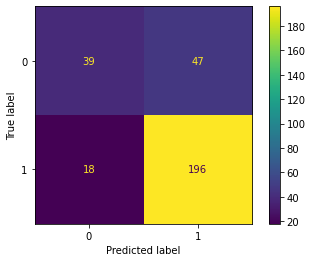

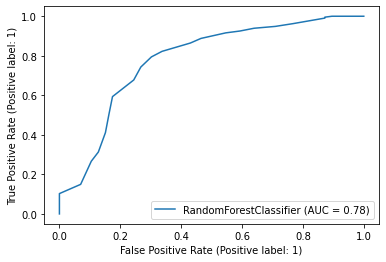

In [11]:
# random forest
rf_params = {
    "n_estimators":30,
    "criterion": "entropy",
}

train_skmodel(Model=RandomForestClassifier, dict_params=rf_params, experiment_name="rf-experiment")

/home/lps/anaconda3/envs/ia/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022/03/11 12:30:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lps/anaconda3/envs/ia/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/03/11 12:30:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/lps/anaconda3/envs/ia/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is dep

Modelo:  f238d8060f99420e8f5fb54d75b45f1a


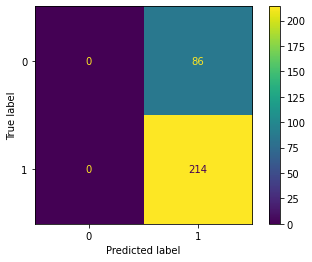

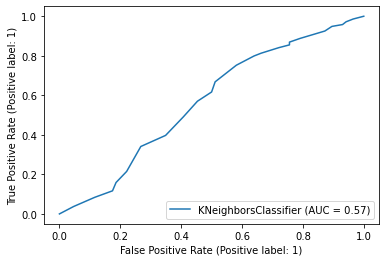

In [12]:
# k-nearest neighbors
knn_params = {
    "n_neighbors":120,
    "weights": "uniform",
    "leaf_size": 30,
}

train_skmodel(Model=KNeighborsClassifier, dict_params=knn_params, experiment_name="knn-experiment")